In [1]:
import pschitt.emission as em
import pschitt.vizualisation as viz
import pschitt.sky_objects as sky
import pschitt.geometry as geo
import pschitt.camera_image as ci
from pschitt import hillas
import numpy as np
import matplotlib.pyplot as plt
import math
import pschitt.dataset as ds
from ipywidgets import interact, interactive, fixed, interact_manual, widgets

In [2]:
import matplotlib
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

font = {'size'   : 20}
matplotlib.rc('font', **font)
plt.set_cmap('viridis')

In [3]:
def plot_array(telescope_array, ax=None, **kwargs):
    """
    Plot a map of the telescopes array

    Parameters
    ----------
    telescope_array: list of telescopes classes
    """

    ax = plt.gca() if ax is None else ax

    colors = ['#8dd3c7', '#fb8072','#ffffb3','#bebada','#80b1d3','#fdb462','#b3de69']
    if 'c' not in kwargs and 'color' not in kwargs:
        change_color=True
    else:
        change_color=False
    
    for tel in telescope_array:
        if change_color:
            kwargs['color'] = colors[int(tel.camera_type)]
        ax.scatter(tel.mirror_center[0], tel.mirror_center[1], **kwargs)
        ax.annotate(str(tel.id), (tel.mirror_center[0] + 20, tel.mirror_center[1] + 20))
    ax.axis('equal')
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")

    return ax


def plot_hillas_direction(telescopes, hillas_parameters, ax=None, **kwargs):
    """
    Plot the reconstructed directions on the ground from Hillas parameters
    """
    ax = plt.gca() if ax is None else ax
    
    for (tel, hp) in zip(triggered_telescopes, hillas_parameters):
        alt, az = geo.normal_to_altaz(tel.normal)
        psi_g = geo.direction_ground(hp[7] + np.pi/2., alt, az)
        ax.plot(x * np.cos(psi_g) + tel.mirror_center[0], x * np.sin(psi_g) + tel.mirror_center[1], **kwargs)
        
    return ax


def angles_to_particles(position, shower):
    """
    compute all the angles between the given position and particles
    """
    n = geo.altaz_to_normal(shower.alt, shower.az)
    m = shower.particles - position
    m_norm = np.linalg.norm(m, axis=1)
    m = m/np.transpose([m_norm, m_norm, m_norm])
    return np.arccos(np.dot(n, m.T))
  
def ground_intensity(position, shower):
    angles = angles_to_particles(position, shower)
    return shower.particles_angular_emission_profile(angles, **shower.particles_angular_emission_profile_kwargs).sum()

def intensity_map(shower, x=np.linspace(-2000, 2000), y=np.linspace(-2000, 2000)):
    """
    intensity map of the shower light on the ground
    """
    I_map = np.empty((x.size, y.size))
    for i in range(x.size):
        for j in range(y.size):
            position = np.array([x[i], y[j], 0])
            I_map[i,j] = ground_intensity(position, shower)
    return I_map

In [4]:
shower = sky.shower()

shower.impact_point = np.array([500,500,0])

#shower direction
shower.alt = math.radians(30)
shower.az = math.radians(0)

#pointing direction off-axis
talt = math.radians(30)
taz = math.radians(0)

#shower parameters
shower_top = 12000
shower_length = 8000
shower_width = 200

shower.number_of_particles = int(1e4)

shower.gaussian_ellipsoide(shower_top, shower_length, shower_width)

tel_normal = geo.altaz_to_normal(talt,taz)
# tel1 = geo.Telescope([0,0,0],tel_normal)
# tel2 = geo.Telescope([200,0,0],tel_normal)
# tel3 = geo.Telescope([400,0,0],tel_normal)
# tel4 = geo.Telescope([800,0,0],tel_normal)
# tel5 = geo.Telescope([0,400,0],tel_normal)

# alltel = [tel1, tel2, tel3, tel4, tel5]

# alltel = geo.load_telescopes(ds.get('CTA_paranal.txt'), normal=tel_normal)
alltel = geo.load_telescopes('../share/arrays/CTA_paranal.txt', normal=geo.altaz_to_normal(talt, taz))
for i, tel in enumerate(alltel):
    tel.id = i+1
trigger_intensity = 10.
noise = 0

shower.particles_angular_emission_profile = em.angular_profile.lgdt06
shower.particles_angular_emission_profile_kwargs = {'eta':0.01}
# shower.particles_angular_emission_profile = em.angular_profile.constant

ci.array_shower_imaging(shower, alltel, noise)

# Compute the Cherenkov light intensity map on the ground
x = np.linspace(-1500,1500,100)
y = np.linspace(-1500,1500,100)
xg, yg = np.meshgrid(x, y)
I_map = intensity_map(shower, x, y)

# Hillas reconstruction
HP, triggered_telescopes = hillas.array_hillas_parameters(alltel, trigger_intensity)
print("{} triggered telescopes".format(len(triggered_telescopes)))
if len(triggered_telescopes)>1:
    pa = hillas.impact_parameter_average(triggered_telescopes, HP)
    p = hillas.impact_parameter_ponderated(triggered_telescopes, HP)

100 telescopes loaded
45 triggered telescopes


In [333]:
x = np.linspace(-1500,1500,100)
y = np.linspace(-1500,1500,100)
xg, yg = np.meshgrid(x, y)
I_map = viz.intensity_map(shower, x, y)

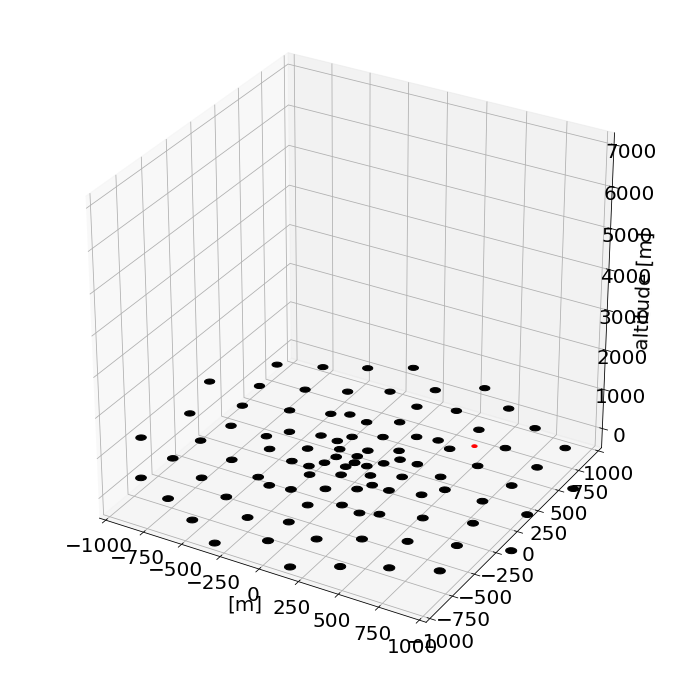

In [334]:
viz.plot_shower3d(shower, alltel, density_color=True)

In [8]:
@interact(tel_id=widgets.Dropdown(options=np.arange(1,len(alltel)+1), description="Telescope"), reco_direction=widgets.Checkbox())
def f(tel_id, reco_direction=False): 
    fig, axes = plt.subplots(1,2,figsize=(42,20), gridspec_kw = {'width_ratios':[5, 3]});
    

    axes[0] = viz.plot_intensity_map(xg, yg, I_map, ax=axes[0])
    axes[0] = plot_array(alltel, ax=axes[0], s=150, alpha=0.6)
    axes[0] = plot_array([alltel[tel_id-1]], ax=axes[0], color='red', s=250)
    if reco_direction:
        axes[0] = plot_hillas_direction(triggered_telescopes, HP, ax=axes[0], color='grey', alpha=0.7)
    
    axes[1] = viz.display_camera_image(alltel[tel_id-1], s=140, ax=axes[1]);
    
    axes[1].set_title("Telescope {}".format(alltel[tel_id-1].id), fontsize=20);
    axes[0].scatter(shower.impact_point[0], shower.impact_point[1], color='black', label='Impact point', marker="x", s=300)
    axes[0].set_xlim(-1500,1500)
    axes[0].set_ylim(-1500,1500)
    axes[0].legend()
    


interactive(children=(Dropdown(description='Telescope', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14…

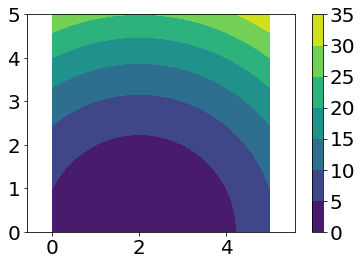

In [299]:
x = np.linspace(0, 5, 50)
y = np.linspace(0, 5, 40)

X, Y = np.meshgrid(x, y)
Z = (X-2)**2 + Y**2

plt.contourf(X, Y, Z)
plt.axis('equal')
plt.colorbar()